In [95]:
# default_exp transforms

## Transofrms

> Classes and helper function for doing transforms

In [96]:
from pathlib import Path
from nbdev_template.utils import *
import torch
import inspect
from nbdev.showdoc import *
from fastcore.test import *
import numpy as np
import matplotlib.pyplot as plt

In [97]:
#export 
import inspect
import torch
from torchvision.transforms import Normalize
from nbdev_template.utils import *

In [98]:
TRN_IMG_3D_P = Path('/nrs/turaga/smlm_data/SvobodaWang_mFISH/sample.ALM.tif')
TRN_IMG_3D = torch.tensor(tiff_imread(TRN_IMG_3D_P).astype('float32'));
TRN_IMG_3D_small = TRN_IMG_3D[:, 1, 0:100, 200:300];

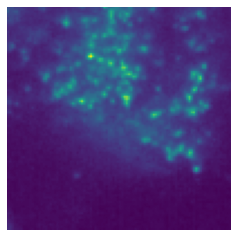

In [99]:
show_image(TRN_IMG_3D_small[0])

In [100]:
M_3D = TRN_IMG_3D_small

In [101]:
#export
def print_clas_signature(self, nms):
    "print class signature"
    mod = inspect.currentframe().f_back.f_locals
    for n in nms: 
        print(f'{n}: {getattr(self,n)}')
        
class TransfromBase:
    '''
    All transformations optianally must be inherited from this class for ncie 
    representations and checks if input to given transformations is tensor
    
    '''
    def __repr__(self):
        print (f'Transform({self.__class__.__name__})')
        name = inspect.signature(self.__class__).parameters.keys()
        print_clas_signature(self, name)
        return ''
    
    def __call__(self, x):
        tst_check_tensor(x)

    @staticmethod
    def _get_device(x):
        return getattr(x, 'device')
        


In [102]:
show_doc(TransfromBase)

<h2 id="TransfromBase" class="doc_header"><code>class</code> <code>TransfromBase</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>TransfromBase</code>()

All transformations optianally must be inherited from this class for ncie 
representations and checks if input to given transformations is tensor

In [103]:
class DumyTransform(TransfromBase):
    def __init__(self, k=3):
        self.k = k
    def __call__(self, x):
        super().__call__(x)
        return x + self.k

In [104]:
val = 6
dummy_x = torch.tensor(4)
dummy_t = DumyTransform(val)

In [105]:
dummy_t

Transform(DumyTransform)
k: 6


In [106]:
test_eq(dummy_t.k, val)
test_eq(dummy_t(dummy_x), dummy_x+val)
test_eq(type(dummy_t(dummy_x)), torch.Tensor)
test_fail(lambda : test_eq(dummy_t(np.array(6)), 10))

In [107]:
#export
class ScaleTensor(TransfromBase):
    """
    \nScales given `torch.Tensor` between `low` and `high`
    
    \nParameters:
    \n`low`     : lower bound
    \n`high`    : upper bound
    \n`data_min`: max value of data
    \n`data_max`: min value of main data  

    \nReturns:
    \nScaled tensor
    
    """
    def __init__(self, low: float, high: float, data_min: float=0., data_max: float =1.):
        self.low = low
        self.high = high
        self.data_min = data_min
        self.data_max = data_max
        self.ratio = (self.high-self.low) /(self.data_max-self.data_min)
        
    def __call__(self, x) -> torch.Tensor:
        super().__call__(x)
        return self.ratio * x + self.low- self.data_min * self.ratio

In [108]:
show_doc(ScaleTensor)

<h2 id="ScaleTensor" class="doc_header"><code>class</code> <code>ScaleTensor</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ScaleTensor</code>(**`low`**:`float`, **`high`**:`float`, **`data_min`**:`float`=*`0.0`*, **`data_max`**:`float`=*`1.0`*) :: [`TransfromBase`](/nbdev_template/transforms#TransfromBase)

    
Scales given `torch.Tensor` between `low` and `high`
    
    
Parameters:
    
`low`     : lower bound
    
`high`    : upper bound
    
`data_min`: max value of data
    
`data_max`: min value of main data  

    
Returns:
    
Scaled tensor
    
    

In [109]:
low = 0.005
high = 0.01
data_min = 0.
data_max = 1.0
sc = ScaleTensor(low, high, data_min, data_max)
sc

Transform(ScaleTensor)
low: 0.005
high: 0.01
data_min: 0.0
data_max: 1.0


In [110]:
ten = torch.rand(3, 45, 10, 10)
test_eq(callable(sc), True)
test_eq(sc.low,  low)
test_eq(sc.data_min, data_min)
test_eq(sc.ratio, (high-low) /(data_max-data_min))
test_eq(sc(ten).shape, ten.shape)
test_close(sc(ten).min(), low)
test_close(sc(ten).max(), high)

In [111]:
TRN_IMG_3D = TRN_IMG_3D.permute(1, 0, 2, 3)

In [112]:
TRN_IMG_3D.shape

torch.Size([3, 101, 960, 960])

In [113]:
c, h, w, d = TRN_IMG_3D.shape
crop_h, crop_w, crop_d = (64, 64, 64)

In [114]:
#export
class RandomCrop3D(TransfromBase):
    """
    Ramdomly Crops 3D tensor.
    
    \nThis class will generate random crop of `crop_sz`. This calss is initilize 
    with `img_sz` which should be a demension of 4 [Channel, Height, Width, Depth] and 
    a `crop_sz` dimesnion of 3 [Height, Width, Depth] of desired crop. For each crop 
    dimension `_get_slice` function will calculate random int ranging from 0 to (img_sz-crop_sz).
    and return tuple of containing two slice intergers. If one dimension of `img_sz` matches
    one dimension of `crop_sz` the resulting tuple will be `(None, None)` which will result
    in not croping this particular dimension. 
    
    
    \nParameters:
    \n`img_sz`     : Size of the 3D image `(C, H, W, D)`
    \n`crop_sz`    : Size of the 3D crop  `(H, W, D)`

    \nReturns:
    \nCroped 3D image of the given `crop_sz`
    
    """
    def __init__(self, img_sz, crop_sz):
        assert len(img_sz)  == 4 , f'Lenth of img_sz  should be 4 - (C, H, W, D) and not {len(img_sz)}'
        assert len(crop_sz) == 3 , f'Lenth of crop_sz should be 3 not {len(crop_sz)}'
        _, h, w, d = img_sz
        self.img_sz  = tuple((h, w, d))
        self.crop_sz = tuple(crop_sz)
        assert (self.img_sz) >  self.crop_sz
        
        
    def __call__(self, x):
        super().__call__(x)
        slice_hwd = [self._get_slice(i, k) for i, k in zip(self.img_sz, self.crop_sz)]
        return self._crop(x, *slice_hwd)
        
    @staticmethod
    def _get_slice(sz, crop_sz):
        up_bound = sz-crop_sz
        if  up_bound == 0:   
            return None, None
        else:
            l_bound = torch.randint(up_bound, (1,)).item()
        return l_bound, l_bound + crop_sz

    @staticmethod
    def _crop(x, slice_h, slice_w, slice_d):
        return x[:, slice_h[0]:slice_h[1], slice_w[0]:slice_w[1], slice_d[0]:slice_d[1]]
    
#dont have test if channel is first

In [115]:
show_doc(RandomCrop3D)

<h2 id="RandomCrop3D" class="doc_header"><code>class</code> <code>RandomCrop3D</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>RandomCrop3D</code>(**`img_sz`**, **`crop_sz`**) :: [`TransfromBase`](/nbdev_template/transforms#TransfromBase)

    Ramdomly Crops 3D tensor.
    
    
This class will generate random crop of `crop_sz`. This calss is initilize 
    with `img_sz` which should be a demension of 4 [Channel, Height, Width, Depth] and 
    a `crop_sz` dimesnion of 3 [Height, Width, Depth] of desired crop. For each crop 
    dimension `_get_slice` function will calculate random int ranging from 0 to (img_sz-crop_sz).
    and return tuple of containing two slice intergers. If one dimension of `img_sz` matches
    one dimension of `crop_sz` the resulting tuple will be `(None, None)` which will result
    in not croping this particular dimension. 
    
    
    
Parameters:
    
`img_sz`     : Size of the 3D image `(C, H, W, D)`
    
`crop_sz`    : Size of the 3D crop  `(H, W, D)`

    
Returns:
    
Croped 3D image of the given `crop_sz`
    
    

In [123]:
volume_3d = torch.rand(3, 100, 100, 100)
crop_sz = (20, 20, 20)

In [124]:
rand_crop = RandomCrop3D(volume_3d.shape, crop_sz)
rand_crop

Transform(RandomCrop3D)
img_sz: (100, 100, 100)
crop_sz: (20, 20, 20)


In [125]:
rand_crop(volume_3d).shape

torch.Size([3, 20, 20, 20])

In [126]:
test_eq(rand_crop.img_sz, volume_3d.shape[1:])
test_eq(rand_crop.crop_sz, crop_sz)
test_close(max([rand_crop._get_slice(volume_3d.shape[1], crop_sz[0])[1] for i in range(10000)]), volume_3d.shape[1], 1.1)
test_close(max([rand_crop._get_slice(volume_3d.shape[1], crop_sz[0])[0] for i in range(10000)]), volume_3d.shape[1]-crop_sz[0], 1.1)
test_eq(tuple(rand_crop(volume_3d).shape), (volume_3d.shape[0], *crop_sz))
test_eq(callable(rand_crop), True)
test_fail(lambda: test_eq(RandomCrop3D(volume_3d.shape[:-1], crop_sz), RandomCrop3D(volume_3d.shape, crop_sz)))
test_fail(lambda: test_eq(RandomCrop3D(volume_3d.shape, crop_sz[:-1]), RandomCrop3D(volume_3d.shape, crop_sz)))
test_fail(lambda: test_eq(RandomCrop3D(volume_3d.shape[:-2], crop_sz[:-1]), RandomCrop3D(volume_3d.shape, crop_sz)))
test_eq(RandomCrop3D(volume_3d.shape, (100, 20,  20))(volume_3d).shape, (volume_3d.shape[0], 100, 20, 20))
test_eq(RandomCrop3D(volume_3d.shape, (100, 100, 20))(volume_3d).shape, (volume_3d.shape[0], 100, 100, 20))
test_eq(RandomCrop3D(volume_3d.shape, (100, 20, 100))(volume_3d).shape, (volume_3d.shape[0], 100, 20, 100))
test_fail(lambda : test_eq(rand_crop(np.random.rand(3, 100, 100, 100)).shape, rand_crop(volume_3d).shape))
test_eq(rand_crop._get_slice(100, 100), (None, None))

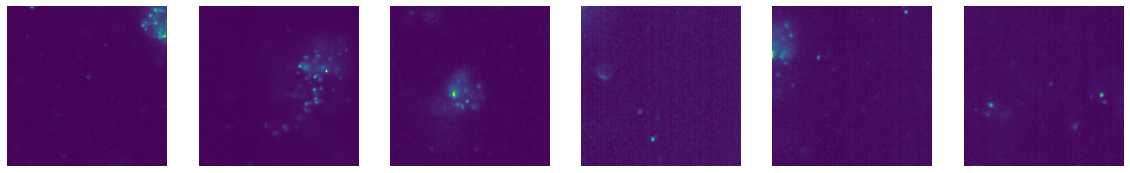

In [127]:
crop_sz = (64, 150, 150)
rand_crop = RandomCrop3D(TRN_IMG_3D.shape, crop_sz)
idx = 10
ch = 1
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in axes.flatten():
    show_image(rand_crop(TRN_IMG_3D).permute(1, 0, 2, 3)[:, ch, :, :][idx], ax=i)

In [128]:
from nbdev.export import *
notebook2script()

Converted 00_models.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted pointsource.ipynb.
Converted transforms.ipynb.
Converted utils.ipynb.
